# Práctica guiada (1h 40min): Regresión Lineal con *energy_consumption.csv*

**Objetivo:** construir, paso a paso, un modelo de **Regresión Lineal** para predecir consumo/energía a partir de variables explicativas.  
**Tiempo sugerido (100 min):**
- 0–10' Setup & carga de datos
- 10–35' EDA básico y limpieza mínima
- 35–60' División train/test y primer modelo lineal
- 60–80' Visualizaciones (pred vs real, residuos)
- 80–95' Iteración (mejoras sencillas)
- 95–100' Conclusiones + preguntas


## 1) Carga de datos (setup)

In [2]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = r"energy_consumption2.csv"  # cambia si tu ruta es distinta
df = pd.read_csv(CSV_PATH)

print("Dimensiones:", df.shape)
df.head()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dimensiones: (5000, 6)


,customer_id,customer_type,regions,building_size_m2,occupants,energy_cost_brl
0,CUSTOMER_0001,residential,Northeast,24,2,64.51
1,CUSTOMER_0002,commercial,Midwest,24,1,55.26
2,CUSTOMER_0003,commercial,Southeast,24,1,74.54
3,CUSTOMER_0004,residential,Northeast,45,4,147.06
4,CUSTOMER_0005,residential,Southeast,45,4,143.06


## 2) Reconocimiento de columnas y configuración mínima

In [5]:
# Intento automático de detectar la variable objetivo (y) y algunas features numéricas (X)
cols = df.columns.tolist()
lower = {c: c.lower() for c in cols}

# Candidatos de objetivo por nombre:
target_keys = ["consumption","energy","target","y","kwh","load","demand"]
target_candidates = [c for c in cols if any(k in lower[c] for k in target_keys)]

# Si no hay candidatos por nombre, toma la última columna numérica
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
TARGET = target_candidates[0] if target_candidates else (num_cols[-1] if num_cols else cols[-1])

# Elige features numéricas (evita el TARGET)
feature_candidates = [c for c in num_cols if c != TARGET]
FEATURES = feature_candidates[:6] if len(feature_candidates) >= 2 else feature_candidates

print("TARGET sugerido:", TARGET)
print("FEATURES sugeridas:", FEATURES)

# Si no te convence, SOBREESCRIBE aquí manualmente:
# TARGET = "nombre_de_tu_columna_objetivo"
# FEATURES = ["col1","col2", ...]


TARGET sugerido: customer_type
FEATURES sugeridas: ['building_size_m2', 'occupants', 'energy_cost_brl']


## 3) EDA básico (10–25 min)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       5000 non-null   object 
 1   customer_type     5000 non-null   object 
 2   regions           5000 non-null   object 
 3   building_size_m2  5000 non-null   int64  
 4   occupants         5000 non-null   int64  
 5   energy_cost_brl   5000 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 234.5+ KB


In [8]:
df.isna().sum()

customer_id         0
customer_type       0
regions             0
building_size_m2    0
occupants           0
energy_cost_brl     0
dtype: int64

In [9]:
df.describe()

,building_size_m2,occupants,energy_cost_brl
count,5000.00000,5000.000000,5000.000000
mean,39.57620,2.301800,86.874028
std,17.51638,1.032729,24.383261
min,17.00000,1.000000,52.520000
25%,24.00000,1.000000,68.557500
50%,45.00000,2.000000,83.715000
75%,45.00000,3.000000,98.242500
max,77.00000,4.000000,158.610000


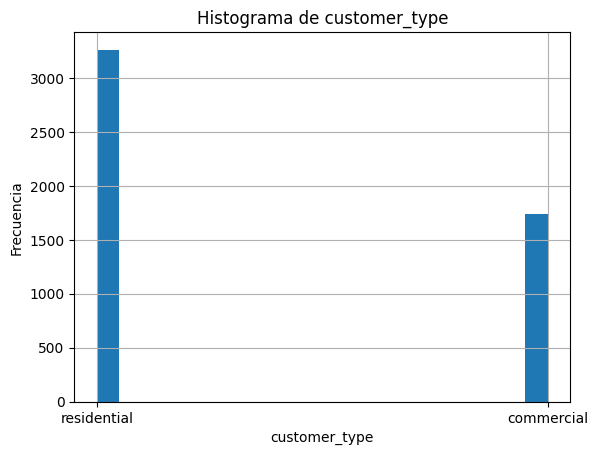

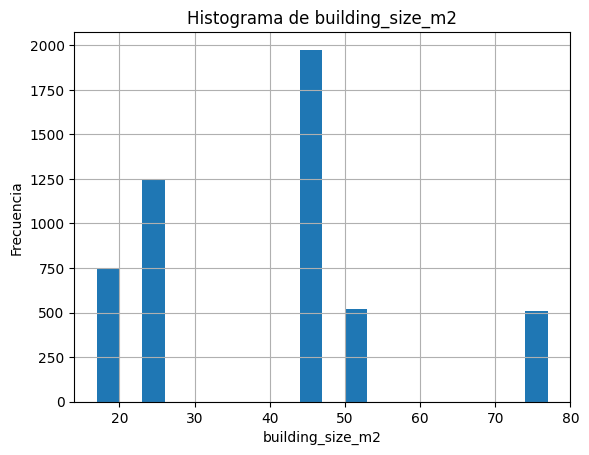

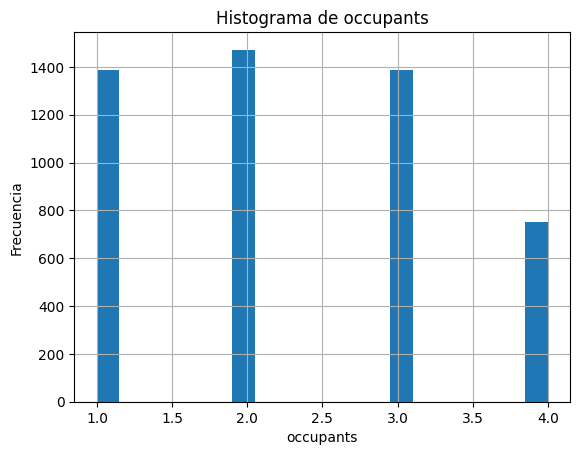

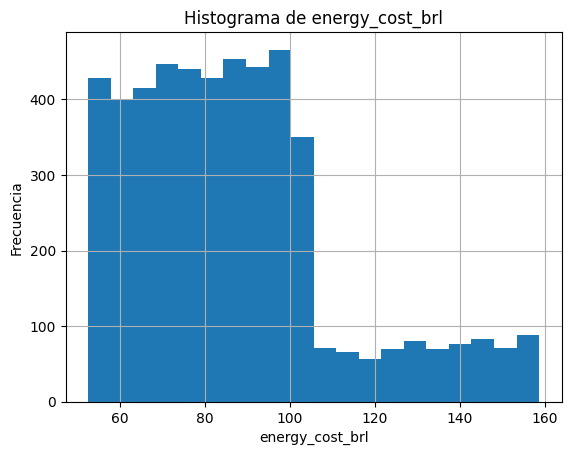

In [10]:
# Histogramas de TARGET y de las primeras 2–3 features
cols_to_plot = [TARGET] + FEATURES[:3]
for c in cols_to_plot:
    plt.figure()
    df[c].hist(bins=20)
    plt.title(f"Histograma de {c}")
    plt.xlabel(c); plt.ylabel("Frecuencia")
    plt.show()

In [ ]:
# Dispersión (scatter) de TARGET vs primeras 2 features
for c in FEATURES[:2]:
    plt.figure()
    plt.scatter(df[c], df[TARGET])
    plt.title(f"{TARGET} vs {c}")
    plt.xlabel(c); plt.ylabel(TARGET)
    plt.show()

**Preguntas rápidas (EDA):**
- ¿Qué variable parece tener relación más clara con el objetivo?
- ¿Detectas valores atípicos evidentes (outliers)?
- ¿Hay nulos? Si los hay, ¿cómo los tratamos? (borrar filas o imputar)

In [6]:
# Limpieza mínima de nulos
df = df.dropna(subset=[TARGET] + FEATURES)
for c in FEATURES:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())
df.shape

(5000, 6)

## 4) Primer modelo: train/test y Regresión Lineal (25–40 min)

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

X = df[FEATURES].values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred = lin.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
pearson_r = float(np.corrcoef(y_test.ravel(), y_pred.ravel())[0, 1])

# --- MÉTRICAS DE EVALUACIÓN ---
# MAE (Mean Absolute Error): error absoluto medio. Promedia cuánto nos equivocamos en unidades
# reales del objetivo (por ejemplo, kWh). Es fácil de interpretar y robusto ante algunos outliers.
#
# RMSE (Root Mean Squared Error): raíz del error cuadrático medio. Penaliza más los errores grandes.
# Útil cuando quieres castigar mucho los fallos grandes.
#
# R^2 (coeficiente de determinación): porcentaje de variabilidad del objetivo que explica el modelo
# respecto a un modelo tonto que siempre predice la media.
# 1.0 es perfecto, 0.0 equivale a la media, y valores negativos indican que el modelo lo hace peor que predecir siempre la media.
# Nota: si el modelo incluye intercepto (lo habitual), R^2 coincide con corr(y, y_pred)^2 en OLS.
#
# Coeficiente de Pearson (r): mide la fuerza y dirección de la relación lineal entre y y y_pred.
# Rango en [-1, 1]: 1 indica correlación positiva perfecta, -1 negativa perfecta, 0 ausencia de relación lineal.
# En OLS con intercepto, r^2 suele aproximar a R^2; pero r aporta el signo (dirección) y puede ser negativo en test si el modelo falla.

print("MAE:", mae)
print("RMSE:", rmse)
print("R^2:", r2)
print("Pearson r:", pearson_r)


ValueError: could not convert string to float: 'residential'

## 5) Visualizaciones clave (20 min)

In [ ]:
# y_pred vs y_test
plt.figure()
plt.scatter(y_test, y_pred)
min_v = min(y_test.min(), y_pred.min())
max_v = max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v])
plt.title("Predicho vs Real (línea ideal y=x)")
plt.xlabel("Real"); plt.ylabel("Predicho")
plt.show()

In [ ]:
# Residuos
res = y_test - y_pred
plt.figure()
plt.scatter(y_pred, res)
plt.axhline(0)
plt.title("Residuos vs Predicción (nube sin patrón = OK)")
plt.xlabel("Predicho"); plt.ylabel("Residuo")
plt.show()

plt.figure()
plt.hist(res, bins=20)
plt.title("Histograma de residuos")
plt.xlabel("Residuo"); plt.ylabel("Frecuencia")
plt.show()

## 6) Itera y mejora (15–20 min)

In [ ]:
# Cambia test_size a 0.4 y comenta cómo cambian las métricas.


### Preguntas finales
- ¿Este es un tipo de problema de aprendizaje Supervisado o No Supervisado? 
- ¿Qué métrica(s) te ha dado más información y por qué?
- ¿Se podría afrontar este problema como un problema de clasificación? ¿Cómo, qué se te ocurre?


---
### Rúbrica breve (10 pts)
1) Carga + EDA (2) · 2) Modelo + métricas (3) · 3) Visualizaciones (2) · 4) Iteración documentada (2) · 5) Preguntas finales (1)
